In [55]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [56]:
import pystan
import numpy as np
import matplotlib.pyplot as pl

In [57]:
truth = np.array([0.5, -1.5])
x = np.sort(np.random.uniform(0, 5, 13))

# Compute the true ys.
y = np.dot(np.vander(x, 2), truth)

# Add in the intrinsic scatter.
true_scatter = 0.2
y += true_scatter * np.random.randn(len(x))

# Add in the uncertainties.
yerr = np.random.uniform(0.05, 0.1, len(x))
y += yerr * np.random.randn(len(x)) 

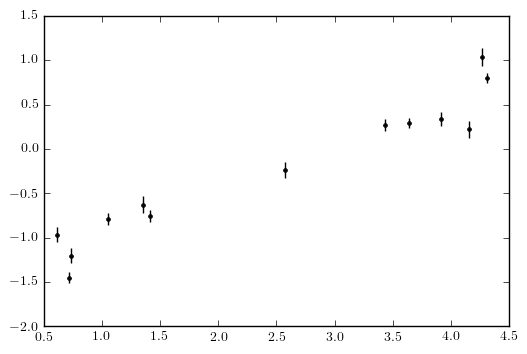

In [58]:
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0);

In [65]:
model_code = """
data {
    int<lower=0> J;          // number of data points
    real x[J];               // independent coordinates
    real y[J];               // observations
    real<lower=0> yerr[J];   // uncertainties
}
parameters {
    real m;
    real b;
    real ln_s;
    real y_true[J];
}
transformed parameters {
    real scatter;
    real y_model[J];
    scatter <- exp(ln_s);
    for (j in 1:J)
        y_model[j] <- m * x[j] + b;
}
model {
    y_true ~ normal(y_model, scatter);
    y ~ normal(y_true, yerr);
}
"""

In [66]:
data = dict(J=len(x), x=x, y=y, yerr=yerr)
fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=4)

/Users/dfm/anaconda/lib/python3.4/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/dfm/anaconda/lib/python3.4/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/dfm/anaconda/lib/python3.4/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/dfm/anaconda/lib/python3.4/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature

In [67]:
results = fit.extract(permuted=True)

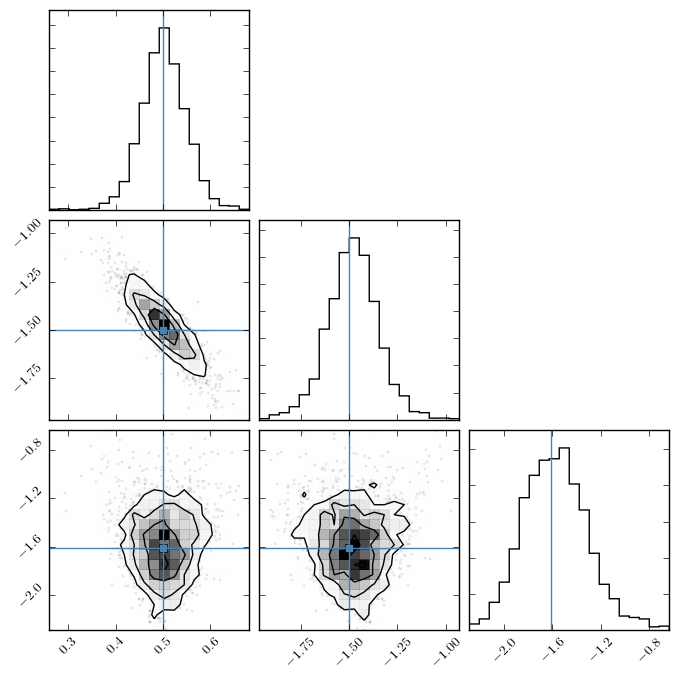

In [68]:
import corner

chain = np.vstack((results["m"], results["b"], results["ln_s"])).T
corner.corner(chain, truths=np.append(truth, np.log(true_scatter)));

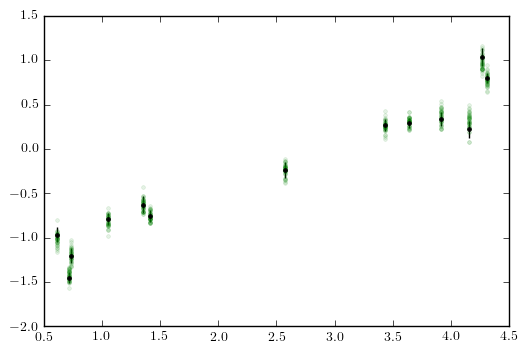

In [71]:
pl.plot(x, results["y_true"][::50].T, ".g", alpha=0.1)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0);